In [1]:
!pip install transformers torch numpy nlpaug nltk scikit-learn matplotlib wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import torch
import nlpaug.augmenter.word as naw
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.utils import class_weight
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:

# Load the dataset
data=pd.read_csv('preprocessed_combined_clean_datasetfinal.csv')
print(data)

# Drop missing values
data.dropna(inplace=True)

                                                     text sentiment  \
0                                              respond go   neutral   
1                                      SAD miss San Diego  negative   
2                                              boss bully  negative   
3                                         interview leave  negative   
4                                         son release buy  negative   
...                                                   ...       ...   
247080  wish we could come see you on denser husband l...  negative   
247081  I have wondered about rake to The client has m...  negative   
247082  say good for both of you Enjoy the break - you...  positive   
247083                          But it was worth it ****.  positive   
247084  All this flirting going on - The at smiles say...   neutral   

        text_length  
0              10.0  
1              18.0  
2              10.0  
3              15.0  
4              15.0  
...            

In [4]:
# Ensure all text data is string type; convert NaNs to empty strings
data['text'] = data['text'].astype(str)

In [5]:

# Label Encoding
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.2, random_state=42)

# Load Pre-trained BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenization Function
def tokenize(texts, max_len=128):
    try:
        encoded_inputs = tokenizer.batch_encode_plus(
            texts,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoded_inputs
    except Exception as e:
        print(f"An error occurred during tokenization: {e}")
        return None

# Tokenize Data
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
train_tokens = tokenize(X_train_list)
test_tokens = tokenize(X_test_list)

# Handle potential tokenization errors
if train_tokens is None or test_tokens is None:
    print("Tokenization failed. Exiting.")
    exit(1)

train_input_ids = train_tokens['input_ids']
train_attention_mask = train_tokens['attention_mask']
test_input_ids = test_tokens['input_ids']
test_attention_mask = test_tokens['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Create Datasets and Loaders
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training Loop with tqdm progress bar
epochs = 5
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    # Training
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as tepoch:
        for batch in tepoch:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            tepoch.set_postfix(loss=total_train_loss / len(tepoch))

    train_losses.append(total_train_loss / len(train_loader))  # Average loss
    train_accuracies.append(correct_train / total_train)  # Average accuracy

    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            # Store labels and probabilities for AUC-ROC calculation
            probs = nn.Softmax(dim=1)(outputs)  # Get prediction probabilities
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_losses.append(total_val_loss / len(test_loader))  # Average validation loss
    val_accuracies.append(correct_val / total_val)  # Average validation accuracy

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')
    print(f'Training Accuracy: {train_accuracies[-1]}, Validation Accuracy: {val_accuracies[-1]}')
# Convert all_labels and all_probs to numpy arrays for ROC calculation
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

Epoch 1/5: 100%|██████████| 6178/6178 [22:12<00:00,  4.64batch/s, loss=0.75]


Epoch 1/5, Training Loss: 0.749742988399334, Validation Loss: 0.7318594564897729
Training Accuracy: 0.6634103648542, Validation Accuracy: 0.6697492765647449


Epoch 2/5: 100%|██████████| 6178/6178 [22:12<00:00,  4.64batch/s, loss=0.74]


Epoch 2/5, Training Loss: 0.7400193244083756, Validation Loss: 0.71901271514908
Training Accuracy: 0.6674626140801748, Validation Accuracy: 0.6769128032863184


Epoch 3/5: 100%|██████████| 6178/6178 [22:13<00:00,  4.63batch/s, loss=0.729]


Epoch 3/5, Training Loss: 0.7294742647701963, Validation Loss: 0.710867142928071
Training Accuracy: 0.6727087844264119, Validation Accuracy: 0.6809195216221139


Epoch 4/5: 100%|██████████| 6178/6178 [22:13<00:00,  4.63batch/s, loss=0.722]


Epoch 4/5, Training Loss: 0.7216001040449649, Validation Loss: 0.6992252936062303
Training Accuracy: 0.678010603638424, Validation Accuracy: 0.6903697108282575


Epoch 5/5: 100%|██████████| 6178/6178 [22:13<00:00,  4.63batch/s, loss=0.712]


Epoch 5/5, Training Loss: 0.7120883766647371, Validation Loss: 0.692217408800588
Training Accuracy: 0.6821185017301739, Validation Accuracy: 0.6931420361414088


In [14]:

# Create a DataFrame to store predictions and true labels
results_df = pd.DataFrame({
    'prediction': all_preds,
    'true_label': all_labels
})

# Save the DataFrame to a CSV file
results_df.to_csv('bert_bilstm_predictions.csv', index=False)

print("Predictions saved to 'bert_bilstm_predictions.csv'")


Predictions saved to 'bert_bilstm_predictions.csv'


In [16]:
import torch
# Save the BERT-BiLSTM model
torch.save(model.state_dict(), 'bert_bilstm_model.pth')

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Assuming all_labels contains the true labels and all_preds contains the predicted labels
# If you haven't done this already:
# all_preds = np.argmax(all_probs, axis=1)  # Get predicted class from probabilities

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, and F1-Score for each class
precision = precision_score(all_labels, all_preds, average=None)  # Precision for each class
recall = recall_score(all_labels, all_preds, average=None)        # Recall for each class
f1 = f1_score(all_labels, all_preds, average=None)                # F1-Score for each class

# Define class names (replace with your actual class names if different)
class_names = ['negative', 'neutral', 'positive']

# Printing results for each class
for i, class_name in enumerate(class_names):
    print(f"{class_name.capitalize()} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1[i]:.2f}")

# Overall Precision, Recall, F1-Score (macro averaging)
overall_precision = precision_score(all_labels, all_preds, average='macro')
overall_recall = recall_score(all_labels, all_preds, average='macro')
overall_f1 = f1_score(all_labels, all_preds, average='macro')

print(f"\nOverall (Macro) Precision: {overall_precision:.2f}")
print(f"Overall (Macro) Recall: {overall_recall:.2f}")
print(f"Overall (Macro) F1-Score: {overall_f1:.2f}")

# Optionally, full classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Accuracy: 0.67
Negative - Precision: 0.64, Recall: 0.69, F1-Score: 0.67
Neutral - Precision: 0.67, Recall: 0.61, F1-Score: 0.64
Positive - Precision: 0.70, Recall: 0.73, F1-Score: 0.71

Overall (Macro) Precision: 0.67
Overall (Macro) Recall: 0.68
Overall (Macro) F1-Score: 0.67

Classification Report:
              precision    recall  f1-score   support

    negative       0.64      0.69      0.67     13810
     neutral       0.67      0.61      0.64     20021
    positive       0.70      0.73      0.71     15586

    accuracy                           0.67     49417
   macro avg       0.67      0.68      0.67     49417
weighted avg       0.67      0.67      0.67     49417



Accuracy: 0.67


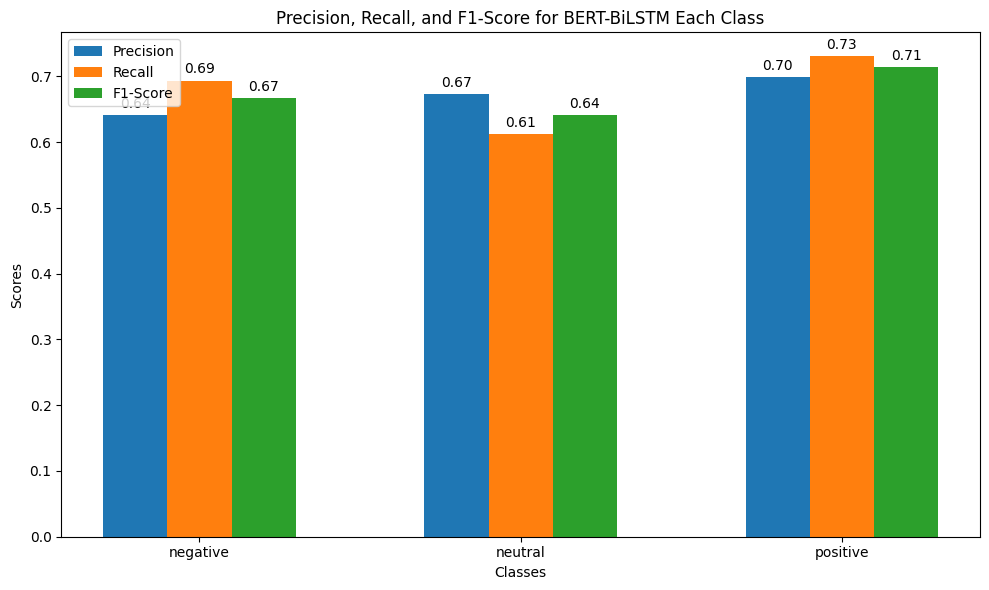

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Assuming all_labels contains the true labels and all_preds contains the predicted labels
# If you haven't done this already:
# all_preds = np.argmax(all_probs, axis=1)  # Get predicted class from probabilities

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.2f}")

# Precision, Recall, and F1-Score for each class
precision = precision_score(all_labels, all_preds, average=None)  # Precision for each class
recall = recall_score(all_labels, all_preds, average=None)        # Recall for each class
f1 = f1_score(all_labels, all_preds, average=None)                # F1-Score for each class

# Define class names (replace with your actual class names if different)
class_names = ['negative', 'neutral', 'positive']

# Plot Precision, Recall, and F1-Score for each class
x = np.arange(len(class_names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each metric
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1, width, label='F1-Score')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for BERT-BiLSTM Each Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Add values on top of the bars
def add_values(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(bars1)
add_values(bars2)
add_values(bars3)

plt.tight_layout()
plt.show()



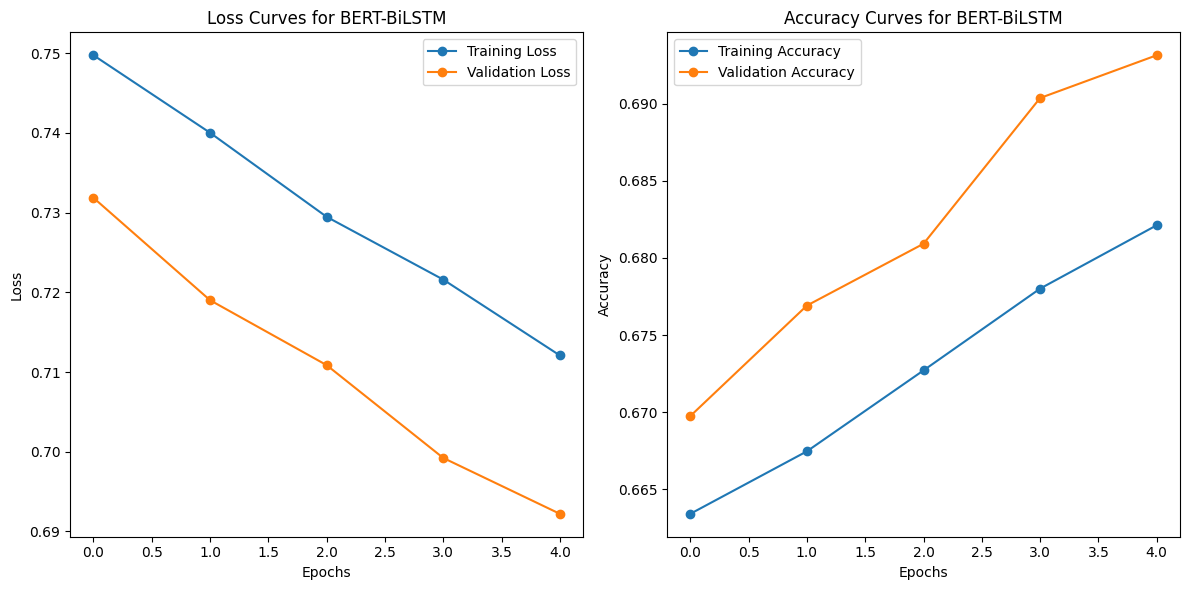

In [21]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss/Accuracy Curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    # Loss Curves
    plt.figure(figsize=[12, 6])

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves for BERT-BiLSTM')
    plt.legend()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves for BERT-BiLSTM')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example call to the function (remove 'history' since it's not used)
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


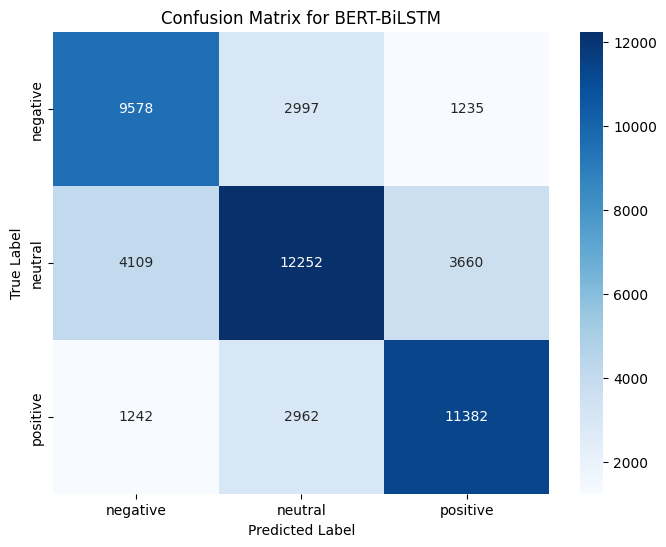

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for BERT-BiLSTM')
plt.show()


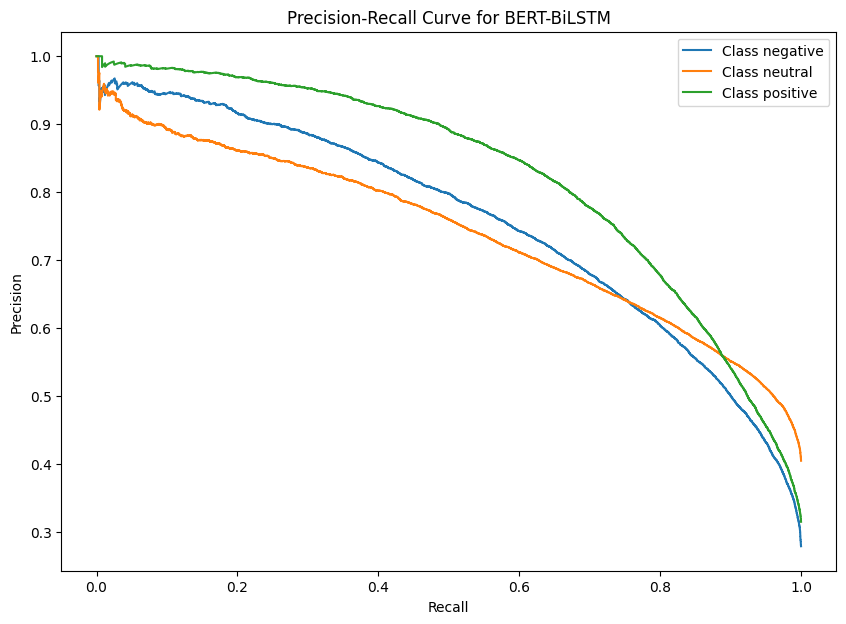

In [27]:
from sklearn.metrics import precision_recall_curve

# Get prediction probabilities
all_probs = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = nn.Softmax(dim=1)(outputs)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute precision-recall curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(le.classes_)):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    plt.plot(recall, precision, label=f'Class {le.classes_[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for BERT-BiLSTM')
plt.legend(loc='best')
plt.show()


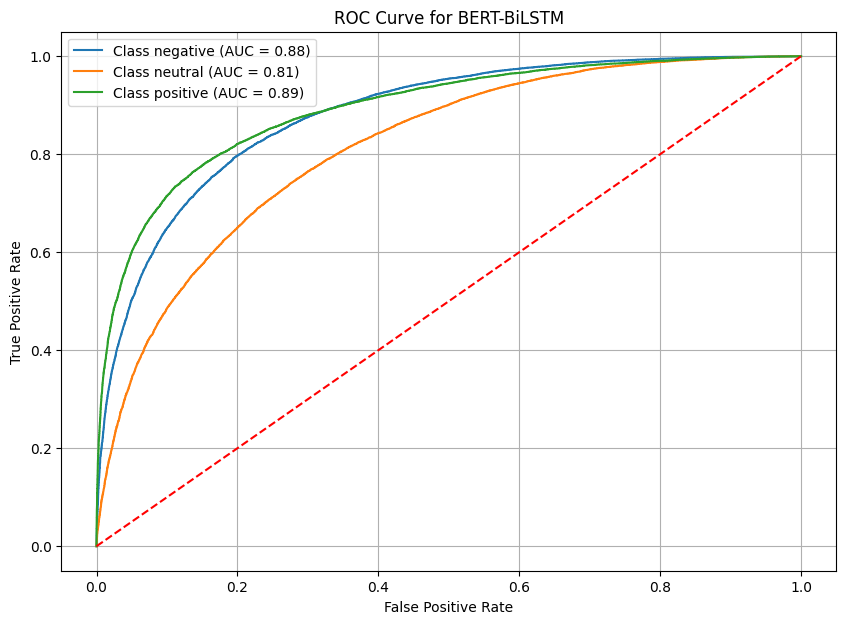

Macro AUC: 0.8622
Weighted AUC: 0.8572


In [28]:
# Plot ROC curve and calculate AUC for each class
plt.figure(figsize=(10, 7))
for i in range(all_probs.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve((all_labels == i).astype(int), all_probs[:, i])
    auc_score = roc_auc_score((all_labels == i).astype(int), all_probs[:, i])
    plt.plot(fpr, tpr, label=f'Class {le.classes_[i]} (AUC = {auc_score:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for BERT-BiLSTM')
plt.legend(loc='best')
plt.grid()
plt.show()

# Calculate overall AUC score (macro and weighted)
macro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
weighted_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')

# Print overall AUC scores
print(f'Macro AUC: {macro_auc:.4f}')
print(f'Weighted AUC: {weighted_auc:.4f}')

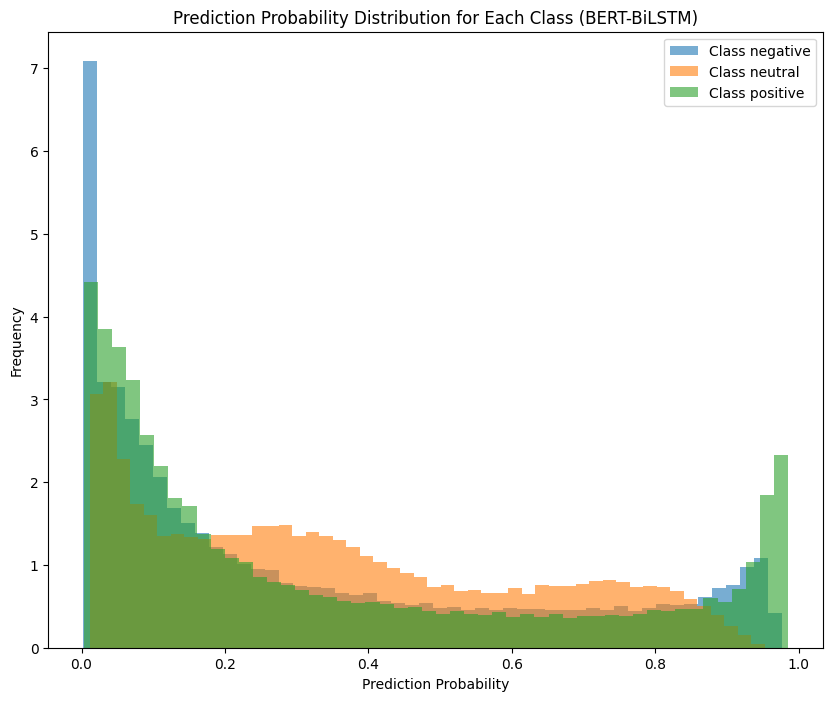

In [31]:
# Plot distribution of prediction probabilities for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    plt.hist(all_probs[:, i], bins=50, alpha=0.6, label=f'Class {le.classes_[i]}', density=True)
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution for Each Class (BERT-BiLSTM)')
plt.legend()
plt.show()




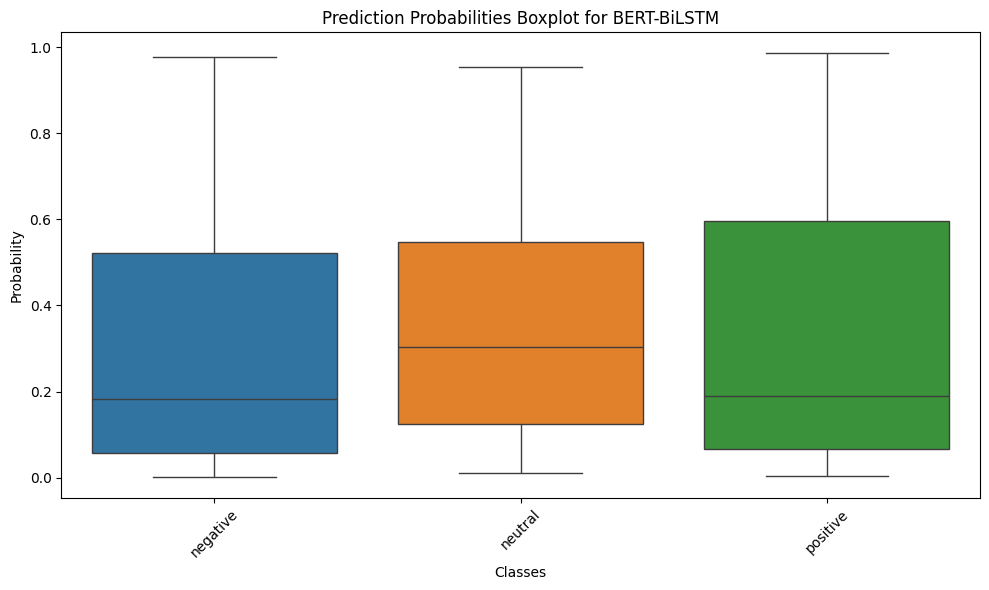

In [30]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert probabilities to a DataFrame for visualization
df_probabilities = pd.DataFrame(all_probs, columns=[f"Class_{i}" for i in range(all_probs.shape[1])])

# Create box plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_probabilities)
plt.title('Prediction Probabilities Boxplot for BERT-BiLSTM')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45)
plt.tight_layout()
plt.show()
